# Kalman filter strat
Basically attempting to implement this: https://www.reddit.com/r/algotrading/comments/obbb5d/kalman_filter_stat_arb/

With help from: 
https://github.com/welly87/epchanbooks/blob/main/book2/KF_beta_EWA_EWC.py

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.formula.api as sm
import statsmodels.tsa.stattools as ts
import statsmodels.tsa.vector_ar.vecm as vm

In [80]:
# BTCUSDT
# ETHUSDT
# DOTUSDT
# ADAUSDT
# LTCUSDT
# ZECUSDT
# XMRUSDT
# ETCUSDT
# XLMUSDT
# BCHUSDT
# EOSUSDT
# DASHUSDT
# NANOUSDT

In [3]:
# ZECUSDT, BCHUSDT
# XMRUSDT

In [105]:
df1 = pd.read_csv("../data/ZECUSDT-minute.csv", index_col=0, parse_dates=True)
df2 = pd.read_csv("../data/XMRUSDT-minute.csv", index_col=0, parse_dates=True)
# df3 = pd.read_csv("../data/LTCUSDT-hour.csv", index_col=0, parse_dates=True)

In [106]:
print(len(df1))
print(len(df2))

1212880
1221532


## Using the CADF Test for Cointegration

In [110]:
df = df1.open.rename("A").to_frame()
df["B"] = df2.open
# df["C"] = df3.close

In [111]:
df = df[4000:]
df = df.dropna()

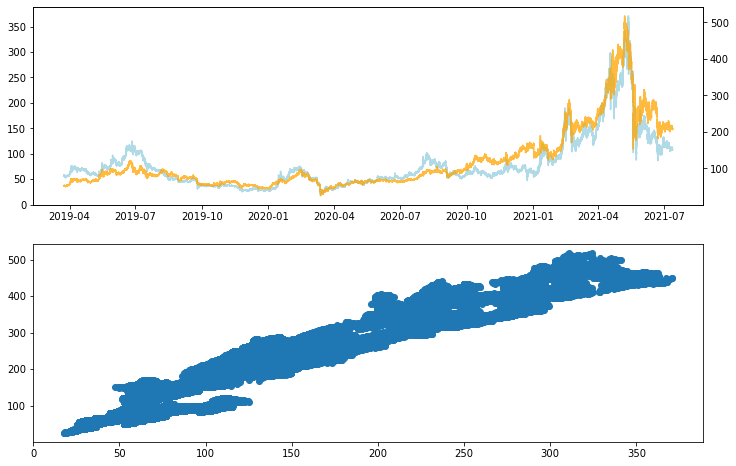

In [112]:
fig, (ax, ax1) = plt.subplots(2, figsize=(12, 8))
ax.plot(df[df.columns[0]], color="lightblue", alpha=.95)
axi = ax.twinx()
axi.plot(df[df.columns[1]], color="orange", alpha=.75)
ax1.scatter(df[df.columns[0]], df[df.columns[1]]);

In [128]:
results = sm.ols(formula="B ~ A", data=df[['B', 'A']]).fit()
results.params[1]

1.534477217835591

In [113]:
results = sm.ols(formula="B ~ A", data=df[['B', 'A']]).fit()
print(results.params)
hedgeRatio = results.params[1]
print('hedgeRatio=%f' % hedgeRatio)

Intercept   -3.445668
A            1.534477
dtype: float64
hedgeRatio=1.534477


<AxesSubplot:xlabel='timestamp'>

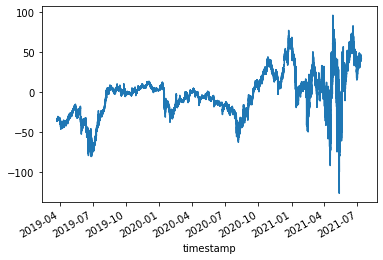

In [114]:
spread = pd.Series((df['B'] - hedgeRatio * df['A'])).rename("spread").to_frame()
spread["mean"] = spread.spread.rolling(2000).mean()
spread["std"] =  spread.spread.rolling(2000).std()
spread["zscore"] = pd.Series((spread["spread"]-spread["mean"])/spread["std"])
spread.spread.plot()

<AxesSubplot:xlabel='timestamp'>

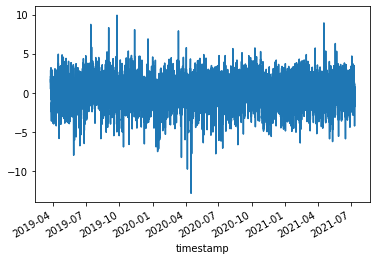

In [115]:
spread.zscore.plot()

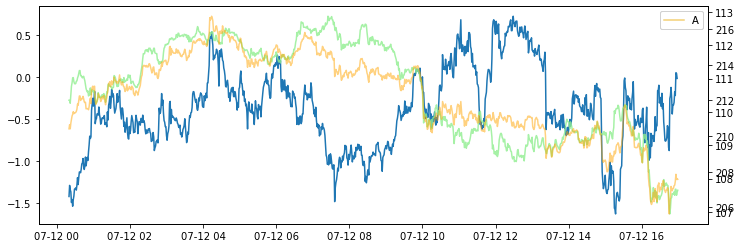

In [116]:
a = -1000
b = -1 #Not None
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(spread.zscore[a:b], alpha=1)
ax1 = ax.twinx()
ax1.plot(df["A"].loc[spread.index[a]:spread.index[b]], label="A", color="lightgreen", alpha=.8)
ax2 = ax.twinx()
ax2.plot(df["B"].loc[spread.index[a]:spread.index[b]], label="A", color="orange", alpha=.5)
ax1.legend()
ax2.legend()

In [117]:
spread = spread.dropna()

In [118]:
spread["A"] = df1["close"].reindex(spread.index)
spread["Ah"] = df1["high"].reindex(spread.index)
spread["Al"] = df1["low"].reindex(spread.index)

spread["B"] = df2["close"].reindex(spread.index)
spread["Bh"] = df2["high"].reindex(spread.index)
spread["Bl"] = df2["low"].reindex(spread.index)

In [119]:
spread

,spread,mean,std,zscore,A,Ah,Al,B,Bh,Bl
timestamp,,,,,,,,,,
2019-03-25 07:59:00,-33.700378,-34.761020,0.643138,1.649167,56.28,56.28,56.28,52.66,52.66,52.66
2019-03-25 08:00:00,-33.780378,-34.760815,0.643385,1.523874,56.28,56.28,56.28,52.58,52.58,52.58
2019-03-25 08:01:00,-33.780378,-34.760611,0.643632,1.522971,56.28,56.28,56.28,52.58,52.58,52.58
2019-03-25 08:02:00,-33.780378,-34.760406,0.643879,1.522069,56.28,56.28,56.28,52.58,52.58,52.58
2019-03-25 08:03:00,-33.780378,-34.760201,0.644125,1.521169,56.28,56.28,56.28,52.58,52.58,52.58
...,...,...,...,...,...,...,...,...,...,...
2021-07-12 16:55:00,42.227493,42.548204,1.473917,-0.217591,107.67,107.70,107.67,207.88,207.88,207.46
2021-07-12 16:56:00,42.627493,42.547330,1.473351,0.054409,107.51,107.68,107.51,207.66,207.86,207.61
2021-07-12 16:57:00,42.613699,42.546442,1.472776,0.045667,107.59,107.64,107.40,207.58,207.72,207.46


In [120]:
import time
import random

In [121]:
start = time.time()
for i in range(10000):
    random.uniform(130.3, 130.4)
time.time()-start

0.007232189178466797

In [122]:
# def get_a_b(al, ac, ah, bl, bc, bh):
#     return random.uniform(al, ac), random.uniform(ac, ah), random.uniform(bl, bc), random.uniform(bc, bh)

def get_a_b(al, ac, ah, bl, bc, bh):
    return ac-abs(ac-al)/2, ac+abs(ac-ah)/2, bc-abs(bc-bl)/2, bc+abs(bc-bh)/2

In [123]:
# Buy  random value between high and low
total = 100.
fee = 0.001       #Set double normal rate
thres = 1.         #2
sell_thres = 1.   # 0, in range [0, ...) for more travel
cusum = []
price_a = None
price_b = None
long = None       #Values: None, "A", "B"
long_a = []
long_b = []
liquidate = []
test = []
trades = 0
mr = -1           #or 1 for not mean reversion
for i in range(spread.shape[0]):
    z = spread.zscore[i]
    if long == None: # Looking to buy
        if z>thres or z<-thres:
            trades += 1
            al, ah, bl, bh = get_a_b(spread.Al[i], spread.A[i], spread.Ah[i], spread.Bl[i], spread.B[i], spread.Bh[i])
            if z>thres: 
                price_a = [ah, ((total/2)/ah)*(1.-fee)]
                price_b = [bl, ((total/2)/bl)*(1.-fee)]
                long = "B"
                long_b.append(spread.index[i])
            elif z<-thres:
                price_a = [al, ((total/2)/al)*(1.-fee)]
                price_b = [bh, ((total/2)/bh)*(1.-fee)]
                long = "A"
                long_a.append(spread.index[i])
    if long == "A" and z>sell_thres: #Liquidate positions
        al, ah, bl, bh = get_a_b(spread.Al[i], spread.A[i], spread.Ah[i], spread.Bl[i], spread.B[i], spread.Bh[i])
        total += (price_a[0] - ah)*price_a[1]-(ah*price_a[1]*fee)
        total += (bl - price_b[0])*price_b[1]-(bl*price_b[1]*fee)
        price_a, price_b, long = None, None, None
        liquidate.append(spread.index[i])
    elif long == "B" and z<-sell_thres: #Liquidate positions
        al, ah, bl, bh = get_a_b(spread.Al[i], spread.A[i], spread.Ah[i], spread.Bl[i], spread.B[i], spread.Bh[i])
        total += (al - price_a[0])*price_a[1]-(al*price_a[1]*fee)
        total += (price_b[0] - bh)*price_b[1]-(bh*price_b[1]*fee)
        price_a, price_b, long = None, None, None
        liquidate.append(spread.index[i])
    cusum.append(total)

In [443]:
total = 100.
fee = 0.003       #Set double normal rate
thres = 2         #2
sell_thres = -1   # 0, in range [0, ...) for more travel
cusum = []
price_a = None
price_b = None
long = None       #Values: None, "A", "B"
long_a = []
long_b = []
liquidate = []
test = []
mr = -1           #or 1 for not mean reversion
for i in range(spread.shape[0]):
    z = spread.zscore[i]
    if long == None: # Looking to buy
        if z>thres or z<-thres:
            price_a = [spread.A[i], ((total/2)/spread.A[i])*(1.-fee)]
            price_b = [spread.B[i], ((total/2)/spread.B[i])*(1.-fee)]
            if z>thres: 
                long = "B"
                long_b.append(spread.index[i])
            elif z<-thres:
                long = "A"
                long_a.append(spread.index[i])
    if long == "A" and z>sell_thres: #Liquidate positions
        total += mr*(spread.A[i] - price_a[0])*price_a[1]-(spread.A[i]*price_a[1]*fee)
        total += mr*(price_b[0] - spread.B[i])*price_b[1]-(spread.B[i]*price_b[1]*fee)
        price_a, price_b, long = None, None, None
        liquidate.append(spread.index[i])
    elif long == "B" and z<-sell_thres: #Liquidate positions
        total += mr*(price_a[0] - spread.A[i])*price_a[1]-(spread.A[i]*price_a[1]*fee)
        total += mr*(spread.B[i] - price_b[0])*price_b[1]-(spread.B[i]*price_b[1]*fee)
        price_a, price_b, long = None, None, None
        liquidate.append(spread.index[i])
    cusum.append(total)

In [37]:
# a = df1[1_000_000:]
# a = abs(a.low-a.close)/a.close

In [38]:
# a.mean()

0.0013644565553943913

773.3681860986459


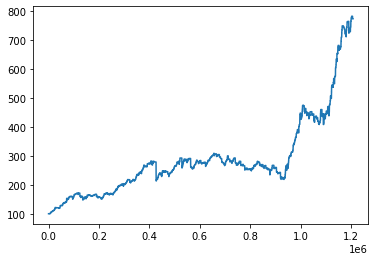

In [124]:
plt.plot(cusum);
print(total)

## Creating side

In [100]:
side_up = pd.Series(1, index=long_a)
side_down = pd.Series(-1, index=long_b)
side = pd.concat([side_up,side_down]).sort_index()
side

2019-03-25 07:59:00   -1
2019-03-27 10:18:00    1
2019-03-28 09:09:00   -1
2019-03-28 19:34:00    1
2019-03-29 14:06:00   -1
                      ..
2021-07-06 18:36:00    1
2021-07-06 22:20:00   -1
2021-07-07 16:29:00    1
2021-07-08 22:54:00   -1
2021-07-11 14:02:00    1
Length: 956, dtype: int64

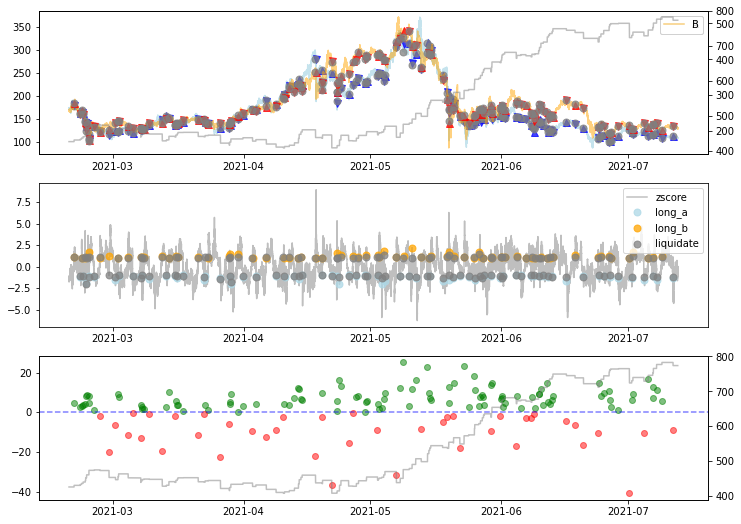

In [130]:
plot = spread
plot["cusum"] = cusum

s = list(pd.Series(cusum).diff())
s = pd.Series(s, index=spread.index)
plot["diffs"] = s[s != 0.]


plot = plot[1000000:] #500_000:700_000

fig, (ax, axz, axc) = plt.subplots(3, figsize=(12,9))

# close_df.loc['2014':].plot(ax=ax, alpha=.5)
ax.plot(plot.A, alpha=.7, color="lightblue", label="A")
ax1 = ax.twinx()
ax1.plot(plot.B, alpha=.5, color="orange", label="B")


ax.plot(plot.A.reindex(long_a), marker='^', markersize=7,
                     alpha=0.75, color='blue', linewidth=0)

ax.plot(plot.A.reindex(long_b), marker='v', markersize=7,
                     alpha=0.75, color='blue', linewidth=0)

ax1.plot(plot.B.reindex(long_b), marker='^', markersize=7,
                     alpha=0.75, color='red', linewidth=0)

ax1.plot(plot.B.reindex(long_a), marker='v', markersize=7,
                     alpha=0.75, color='red', linewidth=0)
ax.plot(plot.A.reindex(liquidate), marker='o', markersize=7,
                     alpha=0.75, color='gray', linewidth=0)
ax1.plot(plot.B.reindex(liquidate), marker='o', markersize=7,
                     alpha=0.75, color='gray', linewidth=0)
ax2 = ax.twinx()
ax2.plot(plot.cusum, color="gray", alpha=.5)
ax.legend()
ax1.legend()

axz.plot(plot.zscore, color="gray", alpha=.5, label="zscore")
axz.plot(plot.zscore.reindex(long_a), marker='o', markersize=7,
                     alpha=0.75, label='long_a', color='lightblue', linewidth=0)
axz.plot(plot.zscore.reindex(long_b), marker='o', markersize=7,
                     alpha=0.75, label='long_b', color='orange', linewidth=0)
axz.plot(plot.zscore.reindex(liquidate), marker='o', markersize=7,
                     alpha=0.75, label='liquidate', color='gray', linewidth=0)
axz.legend()

axc.scatter(plot.index, plot.diffs[plot.diffs > 0].reindex(plot.index), color="green", alpha=.5)
axc.scatter(plot.index, plot.diffs[plot.diffs <= 0].reindex(plot.index), color="red", alpha=.5)
axc.axhline(0, linestyle="--", color="blue", alpha=.5)
axc1 = axc.twinx()
axc1.plot(plot.cusum, color="gray", alpha=.5)


In [220]:
plot.cusum

timestamp
2019-05-05 23:00:00    100.000000
2019-05-06 00:00:00    100.000000
2019-05-06 01:00:00    100.000000
2019-05-06 02:00:00    100.000000
2019-05-06 03:00:00    100.000000
                          ...    
2021-07-10 15:00:00    223.083574
2021-07-10 16:00:00    223.083574
2021-07-10 17:00:00    224.623720
2021-07-10 18:00:00    224.623720
2021-07-10 19:00:00    224.623720
Name: cusum, Length: 19079, dtype: float64

<AxesSubplot:xlabel='timestamp'>

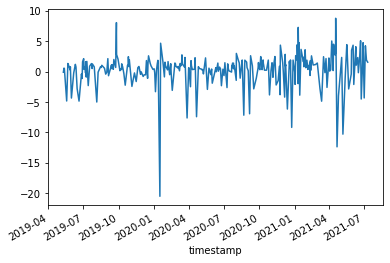

In [42]:
s = list(pd.Series(cusum).diff())
s = pd.Series(s, index=spread.index)
s = s[s != 0.]
s.plot()

In [41]:
s

timestamp
2019-05-05 23:00:00         NaN
2019-05-09 19:00:00   -0.107035
2019-05-11 10:00:00    0.564604
2019-05-12 09:00:00    0.528652
2019-05-18 11:00:00   -4.832214
                         ...   
2021-06-29 11:00:00    1.270078
2021-07-01 13:00:00   -4.332836
2021-07-04 16:00:00    4.232944
2021-07-07 11:00:00    1.873261
2021-07-10 17:00:00    1.540146
Length: 297, dtype: float64

In [189]:
# cadf test
coint_t, pvalue, crit_value = ts.coint(df['B'], df['A'])
print('t-statistic=%f' % coint_t)
print('pvalue=%f' % pvalue)
print(crit_value)

t-statistic=-3.691876
pvalue=0.018771
[-3.89721443 -3.336562   -3.04474985]


### GOOD CADFs
- ETH-XMR: -3.8
- ZEC-XMR: -3.4
- ETH-ADA: -5

In [101]:
# Johansen test
result = vm.coint_johansen(df[['A', 'B']].values, det_order=0, k_ar_diff=1)
print(result.lr1)
print(result.cvt)
print(result.lr2)
print(result.cvm)

[29.57270139  2.71300412]
[[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
[26.85969727  2.71300412]
[[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


In [102]:
# Add IGE for Johansen test
result = vm.coint_johansen(df.values, det_order=0, k_ar_diff=1)
print(result.lr1)
print(result.cvt)
print(result.lr2)
print(result.cvm)

[29.57270139  2.71300412]
[[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
[26.85969727  2.71300412]
[[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


In [103]:
print(result.eig)  # eigenvalues
print(result.evec)  # eigenvectors

[0.00139971 0.00014147]
[[ 0.06064374  0.00190211]
 [-0.03630318  0.01053994]]


<AxesSubplot:>

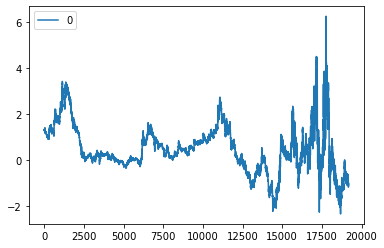

In [104]:
yport = pd.DataFrame(np.dot(df.values, result.evec[:, 0]))  # (net) market value of portfolio
yport.plot()

In [105]:
ylag = yport.shift()
deltaY = yport - ylag
df2 = pd.concat([ylag, deltaY], axis=1)
df2.columns = ['ylag', 'deltaY']
regress_results = sm.ols(formula="deltaY ~ ylag", data=df2).fit()  # Note this can deal with NaN in top row
print(regress_results.params)

Intercept    0.001464
ylag        -0.003435
dtype: float64


In [106]:
halflife = -np.log(2) / regress_results.params['ylag']
print('halflife=%f days' % halflife)

halflife=201.763908 days


APR=0.004612 Sharpe=0.096823


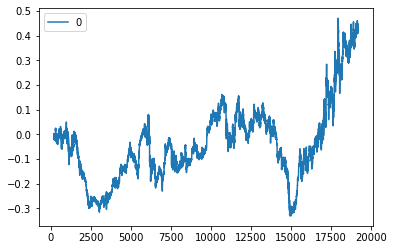

In [107]:
#  Apply a simple linear mean reversion strategy to EWA-EWC-IGE
lookback = np.round(halflife).astype(int)  # setting lookback to the halflife found above
numUnits = -(yport - yport.rolling(lookback).mean()) / yport.rolling(
    lookback).std()  # capital invested in portfolio in dollars.  movingAvg and movingStd are functions from epchan.com/book2
positions = pd.DataFrame(np.dot(numUnits.values, np.expand_dims(result.evec[:, 0],
                                                                axis=1).T) * df.values)  # results.evec(:, 1)' can be viewed as the capital allocation, while positions is the dollar capital in each ETF.
pnl = np.sum((positions.shift().values) * (df.pct_change().values), axis=1)  # daily P&L of the strategy
ret = pnl / np.sum(np.abs(positions.shift()), axis=1)
pd.DataFrame((np.cumprod(1 + ret) - 1)).plot()
print('APR=%f Sharpe=%f' % (np.prod(1 + ret) ** (252 / len(ret)) - 1, np.sqrt(252) * np.mean(ret) / np.std(ret)))
# APR=0.125739 Sharpe=191310

## Co-integration brute-force tests

In [ ]:
# BTCUSDT
# ETHUSDT
# DOTUSDT
# ADAUSDT
# LTCUSDT
# ZECUSDT
# XMRUSDT
# ETCUSDT
# XLMUSDT
# BCHUSDT
# EOSUSDT
# DASHUSDT
# NANOUSDT

In [495]:
stats = pd.DataFrame(columns=["A", "B", "t", "p", "h"])

In [496]:
loc = ["BTCUSDT", "ETHUSDT", "DOTUSDT", "ADAUSDT", "LTCUSDT", "ZECUSDT", "XMRUSDT", "ETCUSDT", "XLMUSDT", "BCHUSDT"]

for a in loc:
    for b in loc[loc.index(a)+1:]:
        print(f"========== {a} and {b} ==========")
        df1 = pd.read_csv(f"../data/{a}-hour.csv", index_col=0, parse_dates=True)
        df2 = pd.read_csv(f"../data/{b}-hour.csv", index_col=0, parse_dates=True)
        df = df1.close.rename("A").to_frame()
        df["B"] = df2.close
        df = df[1000:]
        df = df.dropna()
        # cadf test
        coint_t, pvalue, crit_value = ts.coint(df['B'], df['A'])
        print(f"t-statistic={round(coint_t, 2)}, pvalue={round(pvalue, 2)}, crits={crit_value}")

        result = vm.coint_johansen(df[['A', 'B']].values, det_order=0, k_ar_diff=1)
        yport = pd.DataFrame(np.dot(df.values, result.evec[:, 0]))  # (net) market value of portfolio
        ylag = yport.shift()
        deltaY = yport - ylag
        df2 = pd.concat([ylag, deltaY], axis=1)
        df2.columns = ['ylag', 'deltaY']
        regress_results = sm.ols(formula="deltaY ~ ylag", data=df2).fit()
        halflife = -np.log(2) / regress_results.params['ylag']
        stats.append({"A":a, "B":b, "t":coint_t, "p":pvalue, "h":halflife}, ignore_index=True)
        print(f'halflife={round(halflife, 0)} days')
stats

========== BTCUSDT and ETHUSDT ==========
t-statistic=-2.4, pvalue=0.33, crits=[-3.89677187 -3.33631514 -3.04457851]
halflife=2197.0 days
========== BTCUSDT and DOTUSDT ==========
t-statistic=-2.97, pvalue=0.12, crits=[-3.8978432  -3.33691266 -3.04499323]
halflife=239.0 days
========== BTCUSDT and ADAUSDT ==========
t-statistic=-2.35, pvalue=0.35, crits=[-3.89682765 -3.33634626 -3.04460011]
halflife=1397.0 days
========== BTCUSDT and LTCUSDT ==========
t-statistic=-3.65, pvalue=0.02, crits=[-3.89679128 -3.33632597 -3.04458603]
halflife=821.0 days
========== BTCUSDT and ZECUSDT ==========
t-statistic=-2.95, pvalue=0.12, crits=[-3.89698287 -3.33643284 -3.04466021]
halflife=472.0 days
========== BTCUSDT and XMRUSDT ==========
t-statistic=-2.67, pvalue=0.21, crits=[-3.89697903 -3.3364307  -3.04465872]
halflife=540.0 days
========== BTCUSDT and ETCUSDT ==========
t-statistic=-3.17, pvalue=0.08, crits=[-3.89684698 -3.33635704 -3.04460759]
halflife=1104.0 days
========== BTCUSDT and XLMUSDT =

,A,B,t,p,h
